In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re

# Part 1

In [44]:
with open("amazon.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

products = [] #a list container to store the data

for product_div in soup.find_all("div", class_="s-product-image-container"): #Iterate over all blocks containing the data we need
    try:
        # Filter out only Sponsored listings
        sponsored_label = product_div.find_next("span", class_="puis-label-popover-default")
        if sponsored_label and "Sponsored" in sponsored_label.text:
            # Product container parent (main block)
            main_block = product_div.find_parent("div", class_="a-section")

            # Product Title
            title_tag = main_block.find("h2")
            title = title_tag.text.strip() if title_tag else "N/A"

            # Product URL
            link_tag = title_tag.find_parent("a") if title_tag else None
            product_url = f"https://www.amazon.in{link_tag['href']}" if link_tag else "N/A"

            # Rating
            rating_span = main_block.find("span", class_="a-icon-alt")
            rating = rating_span.text.strip().split()[0] if rating_span else "N/A"

            # Number of Reviews
            ratings_count_tag = main_block.find('span', class_='a-size-small puis-normal-weight-text s-underline-text')
            ratings_count = ratings_count_tag.get_text(strip=True).strip('()') if ratings_count_tag else 'N/A'

            price_whole = main_block.find('span', class_='a-price-whole')
            price = price_whole.get_text(strip=True) if price_whole else 'N/A'

            # Image URL
            img_tag = product_div.find("img", class_="s-image")
            image_url = img_tag['src'] if img_tag and 'src' in img_tag.attrs else "N/A"

            # Brand 
            brand = title.split()[0] if title != "N/A" else "N/A"

            # Save data
            products.append({
                "Title": title,
                "Brand": brand,
                "Reviews": ratings_count,
                "Rating": rating,
                "Selling Price": price,
                "Image URL": image_url,
                "Product URL": product_url
            })
    except Exception as e:
        print("Error while parsing a block:", e)

# Convert to DataFrame and save to CSV
df = pd.DataFrame(products)
df.to_csv("amazon_sponsored_products.csv", index=False)

print("✅ Data extracted and saved to 'amazon_sponsored_products.csv'")


✅ Data extracted and saved to 'amazon_sponsored_products.csv'


# Part 2

In [61]:
df = pd.read_csv("amazon_sponsored_products.csv")
df.head()

,Title,Brand,Reviews,Rating,Selling Price,Image URL,Product URL
0,Storio\n ...,Storio,1.5K,4.2,178,"data:image/svg+xml,<svg xmlns=""http://www.w3.o...",https://www.amazon.inhttps://www.amazon.in/ssp...
1,Webby\n ...,Webby,97,3.4,379,"data:image/webp;base64,UklGRrZCAABXRUJQVlA4IKp...",https://www.amazon.inhttps://www.amazon.in/ssp...
2,Heattack Breathing Soft Teddy Bear Plush Sound...,Heattack,146,4.9,699,"data:image/webp;base64,UklGRuJBAABXRUJQVlA4INZ...",https://www.amazon.inhttps://www.amazon.in/ssp...
3,"Teddyera Dolphin Soft Toy, Cute Cuddly Plush P...",Teddyera,NaN,NaN,750,"data:image/webp;base64,UklGRqRGAABXRUJQVlA4IJh...",https://www.amazon.inhttps://www.amazon.in/ssp...
4,Storio Toy\n ...,Storio,1.5K,4.2,178,"data:image/svg+xml,<svg xmlns=""http://www.w3.o...",https://www.amazon.inhttps://www.amazon.in/Sto...


In [62]:
df.shape

(66, 7)

In [63]:
df.columns

Index(['Title', 'Brand', 'Reviews', 'Rating', 'Selling Price', 'Image URL',
       'Product URL'],
      dtype='object')

In [64]:
df.drop_duplicates(inplace=True)
df.isnull().sum()

Title            0
Brand            0
Reviews          2
Rating           2
Selling Price    0
Image URL        0
Product URL      0
dtype: int64

In [65]:
def convert_reviews(val):
    try:
        val = str(val).strip()
        if 'K' in val:
            return float(val.replace('K', '')) * 1000
        elif val.isdigit():
            return int(val)
        else:
            return float(val)
    except:
        return None

df['Reviews'] = df['Reviews'].apply(convert_reviews)


In [66]:
df['Reviews'] = df['Reviews'].fillna(df['Reviews'].mean()).astype(np.int64)
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df.isnull().sum()

Title            0
Brand            0
Reviews          0
Rating           0
Selling Price    0
Image URL        0
Product URL      0
dtype: int64

In [67]:
df['Selling Price'] = df['Selling Price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
df['Selling Price'] = pd.to_numeric(df['Selling Price'], errors='coerce')
df['Rating'] = df['Rating'].astype(str).str.extract(r'([\d.]+)').astype(float)

df['Reviews'] = df['Reviews'].astype(str).str.replace(',', '', regex=False)
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')


In [68]:
df = df.astype({
    'Selling Price': 'float64',
    'Rating': 'float64',
    'Reviews': 'float64'  # nullable integer type
})


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          66 non-null     object 
 1   Brand          66 non-null     object 
 2   Reviews        66 non-null     float64
 3   Rating         66 non-null     float64
 4   Selling Price  66 non-null     float64
 5   Image URL      66 non-null     object 
 6   Product URL    66 non-null     object 
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


In [70]:
df.head()

,Title,Brand,Reviews,Rating,Selling Price,Image URL,Product URL
0,Storio\n ...,Storio,1500.0,4.200000,178.0,"data:image/svg+xml,<svg xmlns=""http://www.w3.o...",https://www.amazon.inhttps://www.amazon.in/ssp...
1,Webby\n ...,Webby,97.0,3.400000,379.0,"data:image/webp;base64,UklGRrZCAABXRUJQVlA4IKp...",https://www.amazon.inhttps://www.amazon.in/ssp...
2,Heattack Breathing Soft Teddy Bear Plush Sound...,Heattack,146.0,4.900000,699.0,"data:image/webp;base64,UklGRuJBAABXRUJQVlA4INZ...",https://www.amazon.inhttps://www.amazon.in/ssp...
3,"Teddyera Dolphin Soft Toy, Cute Cuddly Plush P...",Teddyera,3079.0,4.135937,750.0,"data:image/webp;base64,UklGRqRGAABXRUJQVlA4IJh...",https://www.amazon.inhttps://www.amazon.in/ssp...
4,Storio Toy\n ...,Storio,1500.0,4.200000,178.0,"data:image/svg+xml,<svg xmlns=""http://www.w3.o...",https://www.amazon.inhttps://www.amazon.in/Sto...


In [71]:
df.describe()


,Reviews,Rating,Selling Price
count,66.000000,66.000000,66.000000
mean,3079.075758,4.135937,382.757576
std,7303.761384,0.481781,448.525278
min,1.000000,1.000000,110.000000
25%,148.000000,4.025000,188.250000
50%,670.000000,4.200000,299.000000
75%,1500.000000,4.375000,399.000000
max,34100.000000,4.900000,3528.000000


# Part 3.1

Top 5 Brands by Frequency:
 Brand
Babique    14
Storio     12
Webby       5
SCOOBA      5
Niku        3
Name: count, dtype: int64


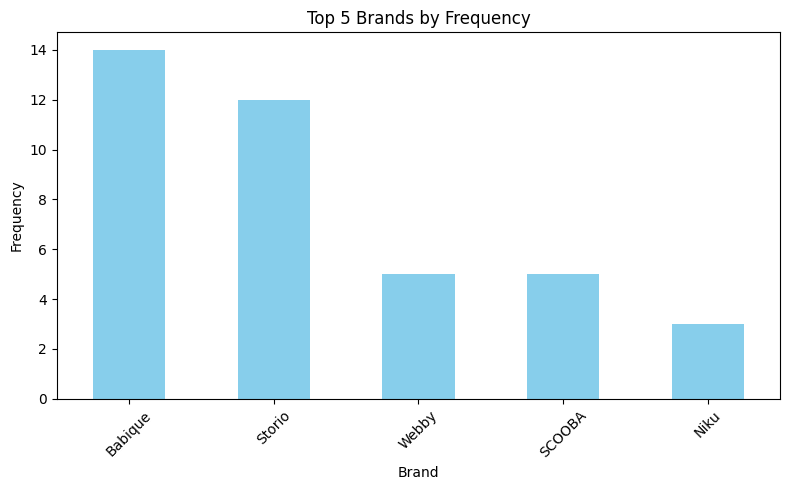

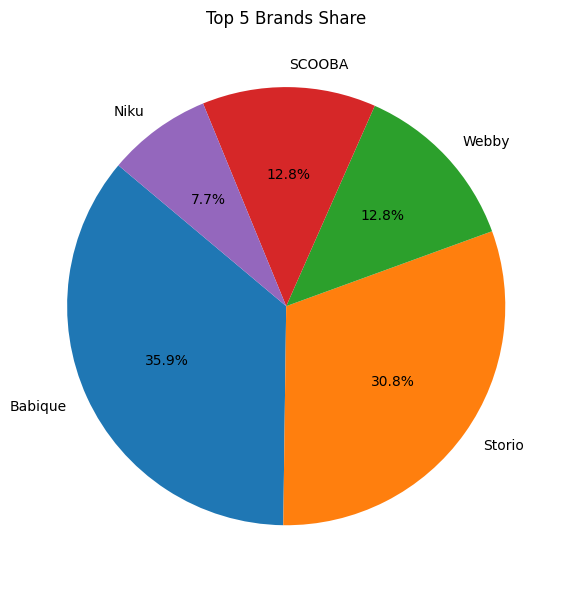


Top 10 Brands by Average Rating:
 Brand
Heattack      4.900000
WILD          4.750000
Wild          4.700000
PlayShifu     4.600000
Mimo          4.500000
Amazon        4.400000
EITHEO        4.400000
Storio        4.233333
SCOOBA        4.220000
One94Store    4.200000
Name: Rating, dtype: float64


In [75]:
# Top 5 brands
brand_counts = df['Brand'].value_counts()
top_5_brands = brand_counts.head(5)
print("Top 5 Brands by Frequency:\n", top_5_brands)

# Bar Chart
plt.figure(figsize=(8, 5))
top_5_brands.plot(kind='bar', color='skyblue')
plt.title('Top 5 Brands by Frequency')
plt.ylabel("Frequency")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart: Share of Top 5 Brands
plt.figure(figsize=(6, 6))
top_5_brands.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Brands Share')
plt.ylabel("")  
plt.tight_layout()
plt.show()

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
brand_avg_rating = df.groupby('Brand')['Rating'].mean().sort_values(ascending=False)

# Show top 10 brands by average rating
print("\nTop 10 Brands by Average Rating:\n", brand_avg_rating.head(10))


In [77]:
print(" Top 5 Brands by Frequency:\n", brand_counts.head(5))

print("\n Top 5 Brands by Average Rating:\n", brand_avg_rating.head(5))

infrequent_highly_rated = brand_avg_rating[~brand_avg_rating.index.isin(top_5_brands.index)].head(5)
print("\n Top 5 Highly Rated but Infrequent Brands:\n", infrequent_highly_rated)


 Top 5 Brands by Frequency:
 Brand
Babique    14
Storio     12
Webby       5
SCOOBA      5
Niku        3
Name: count, dtype: int64

 Top 5 Brands by Average Rating:
 Brand
Heattack     4.90
WILD         4.75
Wild         4.70
PlayShifu    4.60
Mimo         4.50
Name: Rating, dtype: float64

 Top 5 Highly Rated but Infrequent Brands:
 Brand
Heattack     4.90
WILD         4.75
Wild         4.70
PlayShifu    4.60
Mimo         4.50
Name: Rating, dtype: float64


# Part 3.2

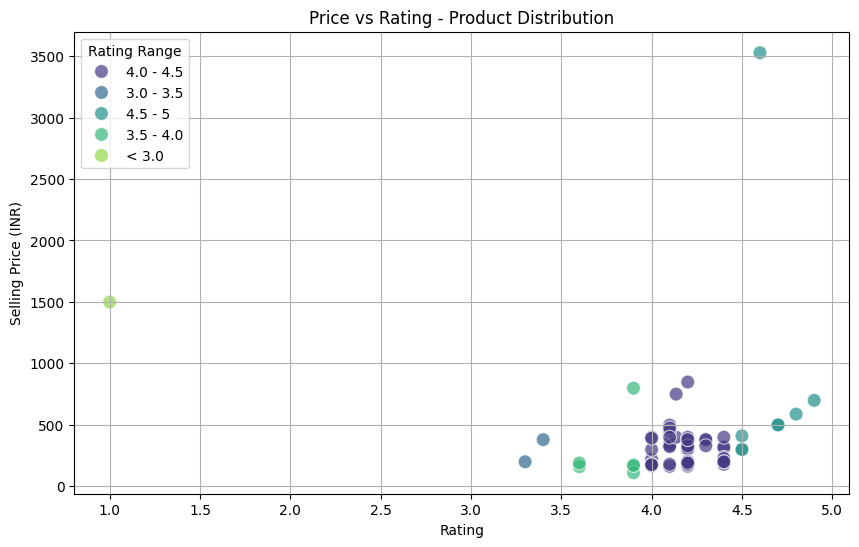

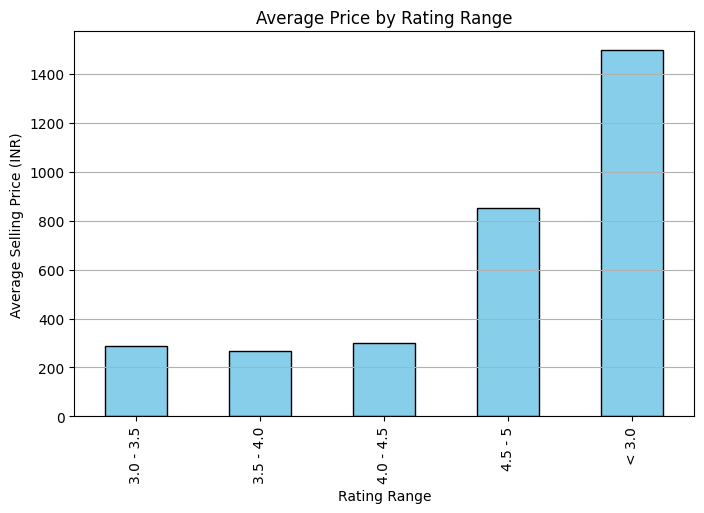

 High Value Products (Low Price, High Rating):
Empty DataFrame
Columns: [Title, Brand, Rating, Selling Price]
Index: []

 Overpriced but Poorly Rated Products:
                                                Title  Brand  Rating  \
64  Meera\n                                       ...  Meera     1.0   

    Selling Price  
64         1499.0  


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clean up (drop rows with missing Rating or Price)
df_clean = df.dropna(subset=['Rating', 'Selling Price'])

# 1️ Create Rating Ranges
def rating_range(r):
    if r >= 4.5:
        return '4.5 - 5'
    elif r >= 4.0:
        return '4.0 - 4.5'
    elif r >= 3.5:
        return '3.5 - 4.0'
    elif r >= 3.0:
        return '3.0 - 3.5'
    else:
        return '< 3.0'

df_clean['Rating Range'] = df_clean['Rating'].apply(rating_range)

# 2️ Average Price by Rating Range
avg_price_by_rating = df_clean.groupby('Rating Range')['Selling Price'].mean().sort_index()

# 3️ High-Value Products: High rating (>=4.5) and low price (bottom 25% price)
price_threshold = df_clean['Selling Price'].quantile(0.25)
high_value_products = df_clean[(df_clean['Rating'] >= 4.5) & (df_clean['Selling Price'] <= price_threshold)]

# 4️ Overpriced, Low-Rated Products
overpriced_poor_products = df_clean[(df_clean['Rating'] < 3.0) & (df_clean['Selling Price'] > df_clean['Selling Price'].quantile(0.75))]

# 5️ Scatter Plot: Price vs Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Rating', y='Selling Price', hue='Rating Range', palette='viridis', s=100, alpha=0.7)
plt.title('Price vs Rating - Product Distribution')
plt.xlabel('Rating')
plt.ylabel('Selling Price (INR)')
plt.grid(True)
plt.show()

# 6️ Bar Plot: Average Price by Rating Range
plt.figure(figsize=(8, 5))
avg_price_by_rating.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Price by Rating Range')
plt.ylabel('Average Selling Price (INR)')
plt.xlabel('Rating Range')
plt.grid(axis='y')
plt.show()

# 7️ Print Outliers
print(" High Value Products (Low Price, High Rating):")
print(high_value_products[['Title', 'Brand', 'Rating', 'Selling Price']])

print("\n Overpriced but Poorly Rated Products:")
print(overpriced_poor_products[['Title', 'Brand', 'Rating', 'Selling Price']])


C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\3999379905.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_by_reviews, x='Reviews', y='Short Title', palette='crest')


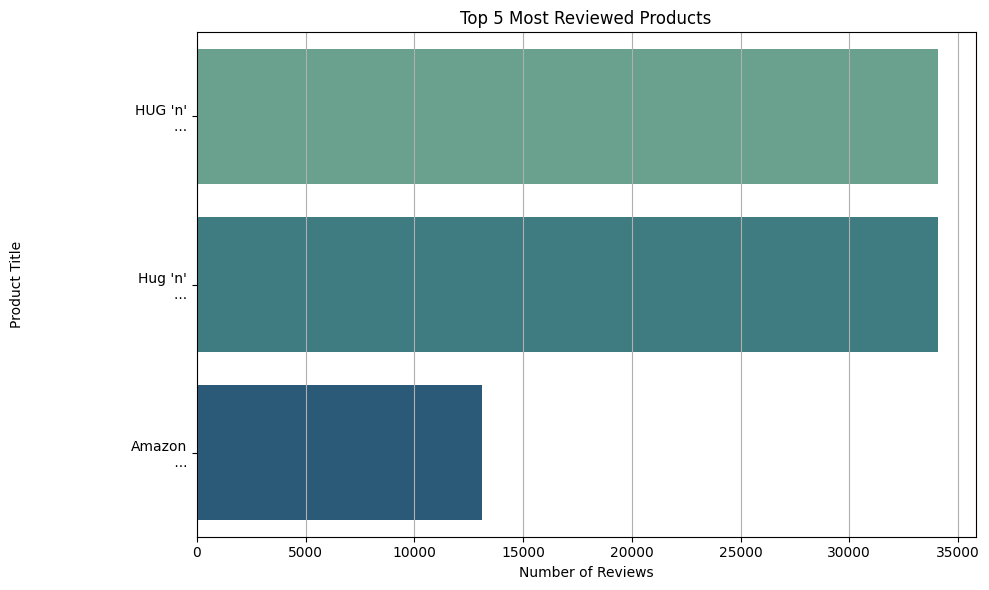

C:\Users\Asus\AppData\Local\Temp\ipykernel_15764\3999379905.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_by_ratings, x='Rating', y='Short Title', palette='viridis')


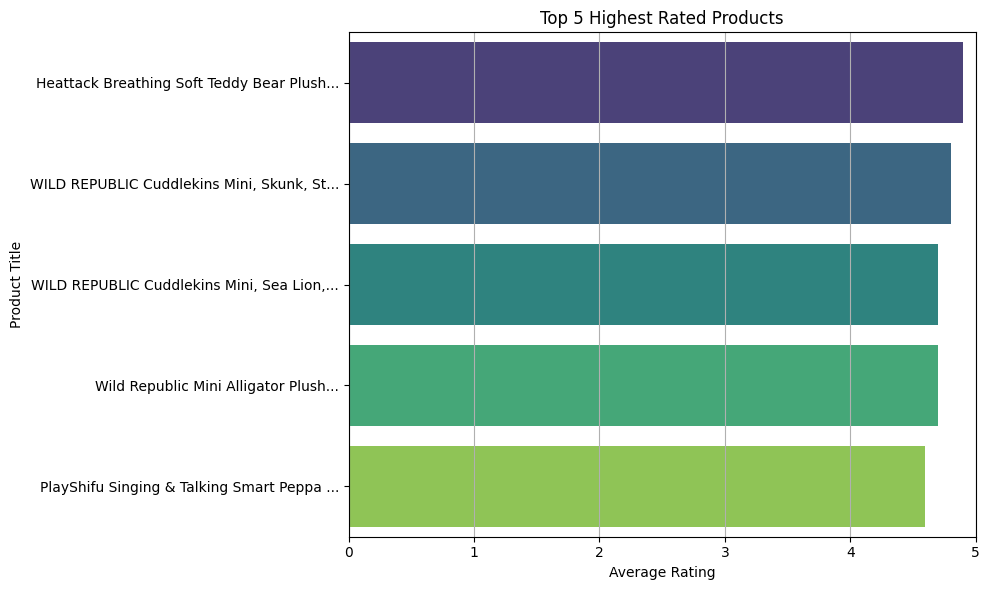

 Best Sellers (High Reviews & Good Rating):
                                                Title     Brand  Reviews  \
3   Teddyera Dolphin Soft Toy, Cute Cuddly Plush P...  Teddyera   3079.0   
12  Babique\n                                     ...   Babique   4600.0   
13  Babique\n                                     ...   Babique   9300.0   
19  Babique\n                                     ...   Babique   3400.0   
23  Amazon\n                                      ...    Amazon  13100.0   
26  HOMECUTE Large Soft Toys Elephant, Big Size Fi...  HOMECUTE   3079.0   
30  Babique\n                                     ...   Babique   2300.0   
33  Webby Soft\n                                  ...     Webby   5800.0   
56  Amazon\n                                      ...    Amazon  13100.0   

      Rating  
3   4.135937  
12  4.100000  
13  4.200000  
19  4.200000  
23  4.400000  
26  4.135937  
30  4.200000  
33  4.400000  
56  4.400000  

 Hidden Gems (High Rating, Low Reviews):
   

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Reviews and Ratings are clean
df_clean = df.dropna(subset=['Reviews', 'Rating'])

# Sort for Top 5 by Reviews and Top 5 by Ratings
top_by_reviews = df_clean.sort_values(by='Reviews', ascending=False).head(5)
top_by_ratings = df_clean.sort_values(by='Rating', ascending=False).head(5)

# Optional: Shorten titles for plot readability
top_by_reviews['Short Title'] = top_by_reviews['Title'].str.slice(0, 40) + '...'
top_by_ratings['Short Title'] = top_by_ratings['Title'].str.slice(0, 40) + '...'

# 1️ Bar Chart - Top 5 by Reviews
plt.figure(figsize=(10, 6))
sns.barplot(data=top_by_reviews, x='Reviews', y='Short Title', palette='crest')
plt.title('Top 5 Most Reviewed Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Product Title')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 2️ Bar Chart - Top 5 by Ratings
plt.figure(figsize=(10, 6))
sns.barplot(data=top_by_ratings, x='Rating', y='Short Title', palette='viridis')
plt.title('Top 5 Highest Rated Products')
plt.xlabel('Average Rating')
plt.ylabel('Product Title')
plt.xlim(0, 5)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# 3️ Combined Insight: Best Sellers = High Reviews + Good Rating
best_sellers = df_clean[(df_clean['Reviews'] > df_clean['Reviews'].quantile(0.75)) &
                        (df_clean['Rating'] > 4.0)]

# 4️ Highly Rated but Less Reviewed (hidden gems)
hidden_gems = df_clean[(df_clean['Rating'] >= 4.5) & (df_clean['Reviews'] <= df_clean['Reviews'].quantile(0.25))]

#  Print Actionable Insights
print(" Best Sellers (High Reviews & Good Rating):")
print(best_sellers[['Title', 'Brand', 'Reviews', 'Rating']])

print("\n Hidden Gems (High Rating, Low Reviews):")
print(hidden_gems[['Title', 'Brand', 'Reviews', 'Rating']])
